In [80]:
'''
  Variational Autoencoder (VAE) with the Keras Functional API.
  adapted from: https://www.machinecurve.com/index.php/2019/12/30/how-to-create-a-variational-autoencoder-with-keras/ (12.12.2021)
  further sources:
  https://danijar.com/building-variational-auto-encoders-in-tensorflow/ (12.12.2021)
  https://keras.io/examples/generative/vae/ (15.12.2021)
  https://pythonprogramming.net/autoencoders-tutorial/ (15.12.2021)
  https://www.geeksforgeeks.org/role-of-kl-divergence-in-variational-autoencoders/ (15.12.2021)
  http://louistiao.me/posts/implementing-variational-autoencoders-in-keras-beyond-the-quickstart-tutorial/ (16.12.2021)
  https://jaketae.github.io/study/vae/ (16.12.2021)
  https://towardsdatascience.com/variational-autoencoders-as-generative-models-with-keras-e0c79415a7eb (16.12.2021)
  https://www.tensorflow.org/tutorials/generative/cvae (16.12.2021)

'''
from helpers.vae import VariationalAutoEncoder
import keras
import tensorflow as tf
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

In [81]:
# Load MNIST dataset
(input_train, target_train), (input_test, target_test) = mnist.load_data()

In [82]:
# Data & model configuration
img_width, img_height = input_train.shape[1], input_train.shape[2]
latent_dim = 2
batch_size = 128
hidden_size = 256
no_epochs = 200
verbosity = 1
num_channels = 1
input_shape = (img_height, img_width, num_channels)

In [83]:
# Reshape data because VAE can also handle rgb images
input_train = input_train.reshape(input_train.shape[0], img_height, img_width, num_channels)
input_test = input_test.reshape(input_test.shape[0], img_height, img_width, num_channels)

# Parse numbers as floats
input_train = input_train.astype('float32')
input_test = input_test.astype('float32')

# Normalize data
input_train = input_train / 255
input_test = input_test / 255

In [84]:
vae = VariationalAutoEncoder(input_shape=input_shape, latent_dim=latent_dim, hidden_size=hidden_size)

In [85]:
# Compile VAE
early_stopping = keras.callbacks.EarlyStopping(monitor="loss", patience=10)
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
vae.compile(optimizer=opt)
# Train autoencoder
history = vae.fit(input_train, input_train, epochs=no_epochs, batch_size=batch_size, validation_data=(input_test, input_test), callbacks=[early_stopping])

Epoch 1/200
469/469 [==============================] - 3s 6ms/step - loss: 47.6264 - val_loss: 43.6735
Epoch 2/200
469/469 [==============================] - 3s 6ms/step - loss: 42.9187 - val_loss: 42.1488
Epoch 3/200
469/469 [==============================] - 3s 5ms/step - loss: 41.6067 - val_loss: 41.0107
Epoch 4/200
469/469 [==============================] - 3s 6ms/step - loss: 40.4147 - val_loss: 40.0277
Epoch 5/200
469/469 [==============================] - 2s 5ms/step - loss: 39.5498 - val_loss: 39.1505
Epoch 6/200
469/469 [==============================] - 3s 6ms/step - loss: 38.8596 - val_loss: 38.6226
Epoch 7/200
469/469 [==============================] - 3s 6ms/step - loss: 38.4322 - val_loss: 38.3405
Epoch 8/200
469/469 [==============================] - 3s 6ms/step - loss: 38.2237 - val_loss: 38.2751
Epoch 9/200
469/469 [==============================] - 3s 6ms/step - loss: 37.9911 - val_loss: 37.9669
Epoch 10/200
469/469 [==============================] - 3s 6ms/step - los

Epoch 80/200
469/469 [==============================] - 3s 6ms/step - loss: 34.5963 - val_loss: 35.2412
Epoch 81/200
469/469 [==============================] - 3s 6ms/step - loss: 34.4126 - val_loss: 35.0038
Epoch 82/200
469/469 [==============================] - 4s 9ms/step - loss: 34.4413 - val_loss: 34.9466
Epoch 83/200
469/469 [==============================] - 3s 6ms/step - loss: 34.4194 - val_loss: 35.0038
Epoch 84/200
469/469 [==============================] - 3s 7ms/step - loss: 34.3730 - val_loss: 34.9980
Epoch 85/200
469/469 [==============================] - 3s 7ms/step - loss: 34.3473 - val_loss: 35.1201
Epoch 86/200
469/469 [==============================] - 3s 7ms/step - loss: 34.3544 - val_loss: 34.9431
Epoch 87/200
469/469 [==============================] - 3s 7ms/step - loss: 34.3699 - val_loss: 34.9023
Epoch 88/200
469/469 [==============================] - 3s 7ms/step - loss: 34.3422 - val_loss: 35.0277
Epoch 89/200
469/469 [==============================] - 3s 6ms/s

In [86]:
# Show vae model structure
vae.summary()

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  267780    
                                                                 
 decoder (Decoder)           multiple                  268048    
                                                                 
Total params: 535,828
Trainable params: 535,828
Non-trainable params: 0
_________________________________________________________________


In [87]:
# Show vae model structure
vae.encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         multiple                  0         
                                                                 
 dense_15 (Dense)            multiple                  200960    
                                                                 
 dense_16 (Dense)            multiple                  65792     
                                                                 
 latent_mu (Dense)           multiple                  514       
                                                                 
 latent_sigma (Dense)        multiple                  514       
                                                                 
 sampling_3 (Sampling)       multiple                  0         
                                                                 
Total params: 267,780
Trainable params: 267,780
Non-trainab

In [88]:
# Show vae model structure
vae.decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            multiple                  768       
                                                                 
 dense_18 (Dense)            multiple                  65792     
                                                                 
 dense_19 (Dense)            multiple                  201488    
                                                                 
 reshape_3 (Reshape)         multiple                  0         
                                                                 
Total params: 268,048
Trainable params: 268,048
Non-trainable params: 0
_________________________________________________________________


### Subtask 1: What activation functions should be used for the mean and standard deviation of the approximate posterior and the likelihood?

The posterior represents the output of the encoder and the likelihood represents the output of the decoder.
In case of the decoder, we do not need any activation function for the mean and the standard deviation because we need the real values between zero and one in order to produce a digit.
The posterior samples $z$ by $z = \mu + e^\frac{\sigma}{2} * \epsilon$ with epsilon chosen randomly from a Normal distribution. Therefore, we should not modify the mean because it determines which digit we will receive. The standard deviation has less of an effect, and it might be useful to avoid that the second part of the sum gets to small in order to provide samples that differ from the mean. A possible activation function is ReLU. But at the same time, we do not want to deviate too much such that we still classify the right digit. So, softplus might be an alternative for an activation function for the standard deviation.
However, we have chosen to use no activation function for posterior and likelihood because we receive the best results without them.

### Subtask 2: What might the reason if we obtain good reconstructed but bad generated digits?

At the moment, we generate digits by randomly choosing the input of the decoder. The VAE has bad results for decoder inputs close to zero and at the borders. The probability to receive a output of the encoder that is a good input for the decoder is higher for reconstructed digits because they already come from a distribution that represents an existing digit. If we know outputs of the encoder that lead to good results for the reconstruction, we can reuse and slightly modify them to achieve better results for generation.

### Subtask 3: Train the VAE

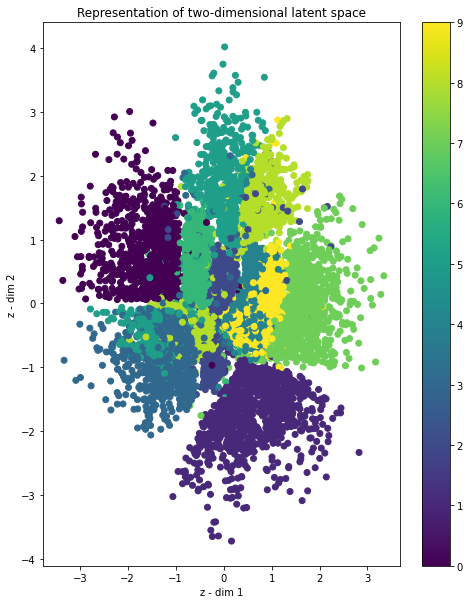

In [89]:
def viz_latent_space(data):
    """
    Visualises the 2 dimensional latent space representing the input data by coloring according to the target data

    Args:
        data (tuple): tuple of input data and target data

    Returns: None
    """
    input_data, target_data = data
    mu, _, _ = vae.encoder(input_data)
    plt.figure(figsize=(8, 10))
    plt.scatter(mu[:, 0], mu[:, 1], c=target_data)
    plt.title("Representation of two-dimensional latent space")
    plt.xlabel('z - dim 1')
    plt.ylabel('z - dim 2')
    plt.colorbar()
    plt.show()

# Plot results
data = (input_test, target_test)
viz_latent_space(data)

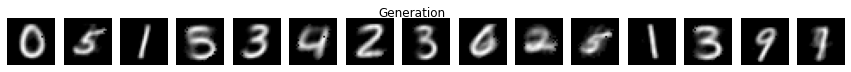

In [90]:
def vis_generation(num_samples):
    """
    Visualises generation of num_samples digits

    Args:
        num_samples (int): number of images that are sampled

    Returns: None
    """
    fig, axs = plt.subplots(1, num_samples, figsize=(num_samples, 1))
    fig.suptitle('Generation')
    for i in range(num_samples):
        z_sample = np.random.normal(size=latent_dim)
        out = vae.decoder(np.array([z_sample]))[0]
        out_reshaped = np.reshape(out,(img_width, img_height, num_channels))
        axs[i].imshow(out_reshaped, cmap="gray")
        axs[i].axis('off')

vis_generation(15)

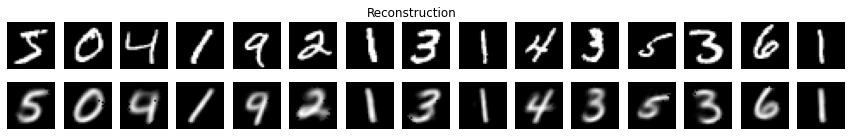

In [91]:
def vis_reconstruction(num_samples):
    """
    Visualises reconstruction of num_samples digits

    Args:
        num_samples (int): number of images that are sampled

    Returns: None
    """
    fig, axs = plt.subplots(2, num_samples, figsize=(num_samples, 2))
    fig.suptitle('Reconstruction')
    for i in range(num_samples):
        axs[0][i].imshow(input_train[i], cmap="gray")
        axs[0][i].axis('off')
    for i in range(num_samples):
        _, _, z = vae.encoder(input_train[i].reshape(-1, 28, 28, 1))
        out = vae.decoder(z)[0]
        axs[1][i].imshow(out, cmap="gray")
        axs[1][i].axis('off')

vis_reconstruction(15)

### Subtask 4: Plot the loss curve

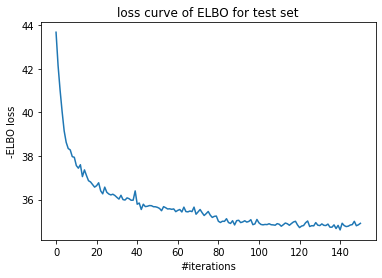

In [92]:
# print loss history
loss_history = history.history['val_loss']

plt.plot(loss_history)
plt.title("loss curve of ELBO for test set")
plt.xlabel('#iterations')
plt.ylabel('-ELBO loss')
plt.show()

### Subtask 5: VAE with latent_dim=32

change latent_dim=32 and rerun

Results:
The system takes longer to converge because there are more parameters to train (more than 200 epochs). The loss is smaller compared to latent_dim=2.
The generation of the digits works not too well, due to the big ranges for input values that are chosen randomly.
The reconstruction of the digits has better results compared to latent_dim=2